##  MNIST handwriting classification using a CNN and PyTorch

In [1]:
import torch

In [2]:
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
# Device configuration
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

device = "cuda" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print(f"Using device: {device}")

Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: cuda


In [4]:
#Downloading the data set

from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [5]:
print(train_data)
print(test_data)
print(train_data.data.size())
print(train_data.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


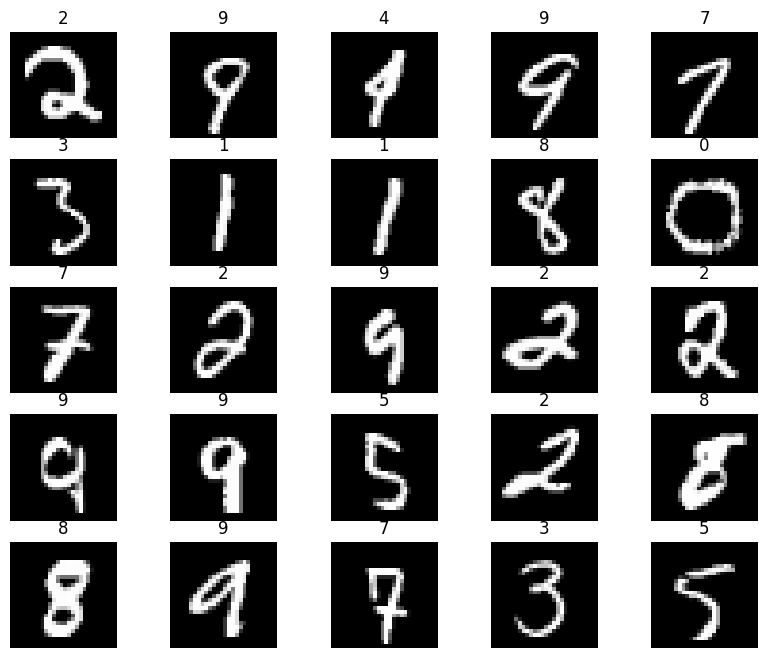

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
#Load data into PyTorch

from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=8),
    
    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True, 
                                          num_workers=8),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x141469210>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1414695d0>}

We will use 2 fully convolutional layers, Relu activation function and MaxPooling. <br> 

Conv2d: Applies a 2D convolution over an input signal composed of several input planes. <br> 

Parameters:  <br> 
in_channels (int) — Number of channels in the input image  <br> 
out_channels (int) — Number of channels produced by the convolution  <br> 
kernel_size (int or tuple) — Size of the convolving kernel <br> 
stride (int or tuple, optional) — Stride of the convolution. Default: 1 <br> 
padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0 <br> 
padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’ <br> 
dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1 <br> 
groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1 <br> 
bias (bool, optional) — If True, adds a learnable bias to the output. Default: True

In [8]:
#Define the CNN class

import torch.nn as nn
class CNN(nn.Module):
    def __init__(self,size_first_kernel=5,output_size=7,padding=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=size_first_kernel,              
                stride=1,                   
                padding=padding,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(nn.Linear(32 * output_size * output_size, 10))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    
class FFN(nn.Module):
    def __init__(self,hidden_units,output_classes):
        super(FFN, self).__init__()
        
        self.hidden_units=hidden_units
        self.output_classes=output_classes
       
        self.feed_forward = nn.Sequential(
            nn.Linear(1*28*28, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_classes)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        output = self.feed_forward(x)
        return output, x    # return x for visualization

### Solution exercise 1: 

The number of weights of a convolutional is equal to: (n_kernels* kernel_dimension)+biases (remember that one kernel has a dimension equal to (n_input_channels,height,width)).

The number of weights of the final fully connected layer is equal to: (input_dimension* output_nodes) + biases.

The convolutional layers have one bias value for each kernel, the fully connected layer has one bias value for each output node.

The max_pooling layer has no weights.

In [9]:
cnn = CNN()
print(cnn)
from torchsummary import summary
from prettytable import PrettyTable

summary(cnn,(1,28,28))

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]       

In [10]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [11]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [12]:
#Train the CNN 

from torch.autograd import Variable

def train(num_epochs, cnn, loaders):
    
    loss_per_step=[]
    steps=[]
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    training_loss=[]
        
    for epoch in range(num_epochs):
        loss_per_epoch=[]
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = images   # batch x
            b_y = labels  # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()   
            
            loss_per_epoch.append(loss.item())
            
            #if (i+1) % 100 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            #           .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        
        print("Mean loss epoch:{} is:{}".format(epoch+1,np.mean(loss_per_epoch)))
        training_loss.append(np.mean(loss_per_epoch))
        
        pass
    plt.plot(np.arange(1,num_epochs+1),training_loss)
    plt.xticks(np.arange(1,num_epochs+1))
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
    return training_loss
    
    pass

def train_ffn(num_epochs, ffn, loaders):
    
    loss_per_step=[]
    steps=[]
    
    ffn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    training_loss=[]
        
    for epoch in range(num_epochs):
        loss_per_epoch=[]
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = images   # batch x
            b_y = labels  # batch y
            output = ffn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()   
            
            loss_per_epoch.append(loss.item())
            
            #if (i+1) % 100 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            #           .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        
        print("Mean loss epoch:{} is:{}".format(epoch+1,np.mean(loss_per_epoch)))
        training_loss.append(np.mean(loss_per_epoch))
        
        pass
    plt.plot(np.arange(1,num_epochs+1),training_loss)
    plt.xticks(np.arange(1,num_epochs+1))
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
    return training_loss
    
    pass


### Solution exercise 3: 

When we change the kernel size of the first convolutional layer, we have to check all the input and output dimensions of each layer of the network. This is done to avoid shape mismatches errors. After this check we can train the network and evaluate the performances. At each step is important to not only re-initialize the convolutional network, but also the optimizer. If the kernel size is too small you will have an error. Of course the kernel size cannot be larger than the image.

analyzing filter dimension:5
Mean loss epoch:1 is:0.1408889717205117
Mean loss epoch:2 is:0.051646983597311194
Mean loss epoch:3 is:0.04221246489580759


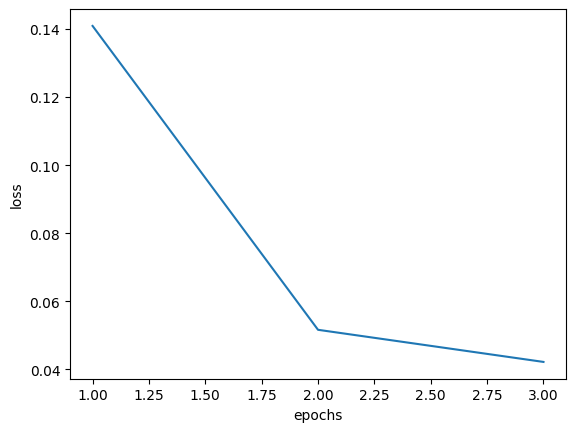

time needed for execution: --- 84.46644687652588 seconds ---
analyzing filter dimension:6
dimensions don't match
analyzing filter dimension:7
dimensions don't match
analyzing filter dimension:8
dimensions don't match
analyzing filter dimension:9
Mean loss epoch:1 is:0.12785929704473042
Mean loss epoch:2 is:0.06090901476622093
Mean loss epoch:3 is:0.057059787540250304


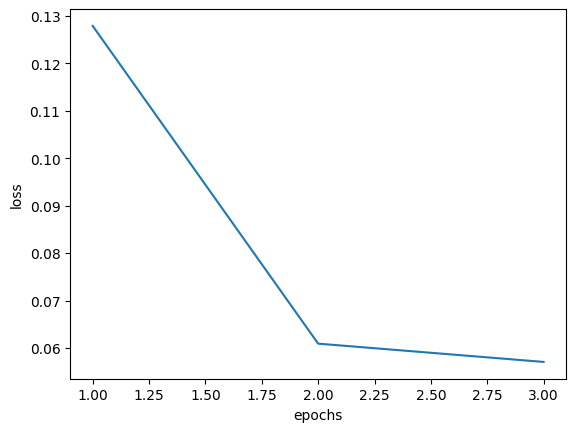

time needed for execution: --- 60.0938720703125 seconds ---
analyzing filter dimension:10
dimensions don't match
analyzing filter dimension:11
dimensions don't match
analyzing filter dimension:12
dimensions don't match
analyzing filter dimension:13
Mean loss epoch:1 is:0.1438110314930479
Mean loss epoch:2 is:0.0795834525913233
Mean loss epoch:3 is:0.0791106409621716


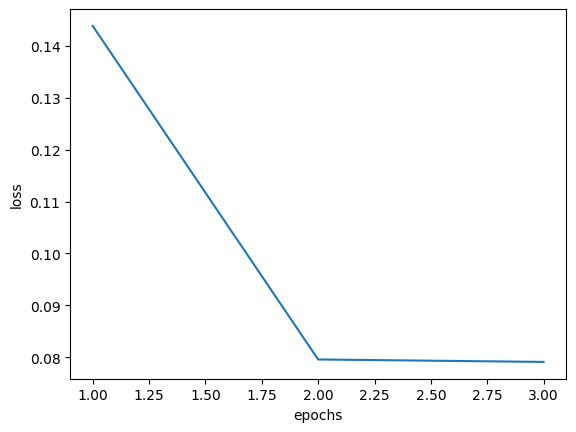

time needed for execution: --- 60.89688515663147 seconds ---
analyzing filter dimension:14
dimensions don't match
analyzing filter dimension:15
dimensions don't match
analyzing filter dimension:16
dimensions don't match
analyzing filter dimension:17
Mean loss epoch:1 is:0.18379676341700057
Mean loss epoch:2 is:0.10791596230895568
Mean loss epoch:3 is:0.10180219351061776


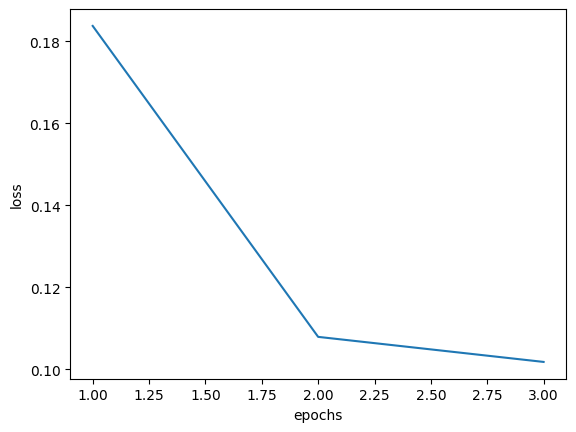

time needed for execution: --- 42.33313179016113 seconds ---
analyzing filter dimension:18
dimensions don't match
analyzing filter dimension:19
dimensions don't match
analyzing filter dimension:20
dimensions don't match
analyzing filter dimension:21
Mean loss epoch:1 is:0.2642333131780227
Mean loss epoch:2 is:0.1423747891994814
Mean loss epoch:3 is:0.13571747064124792


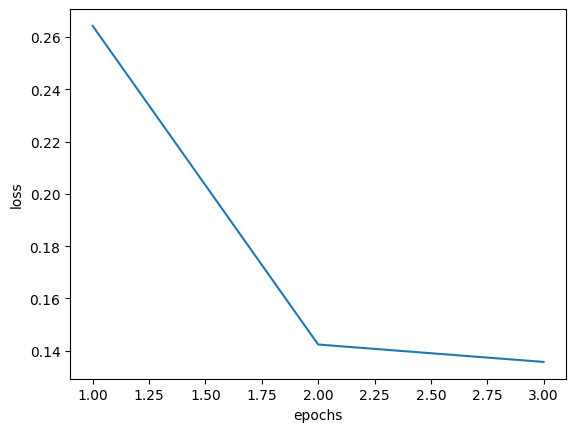

time needed for execution: --- 36.011446952819824 seconds ---
analyzing filter dimension:22
dimensions don't match
analyzing filter dimension:23
dimensions don't match
analyzing filter dimension:24
dimensions don't match


Text(0, 0.5, 'loss')

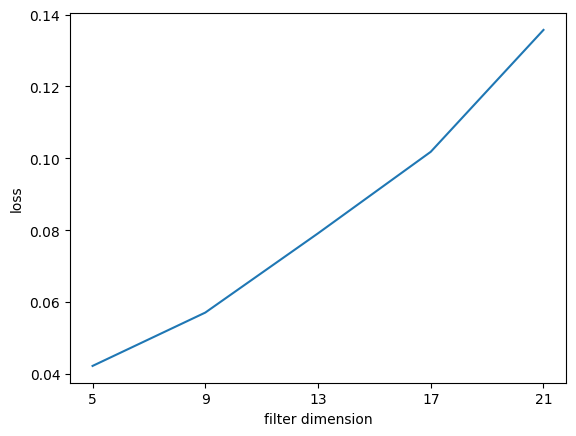

In [13]:

dimension_filter_list=[i for i in range(5,25)]
padding=2
num_epochs=3
loss_per_dimension=[]
analyzed_dimensions=[]

for dimension in dimension_filter_list:
    
    print("analyzing filter dimension:{}".format(dimension))
    
    output_size_first_conv_layer=((28-dimension+2*padding)/1)+1
    output_size_first_max_pooling=((output_size_first_conv_layer-2)/2)+1
    output_size_second_conv_layer=((output_size_first_max_pooling-5+2*2)/1)+1
    output_size_second_max_pooling=((output_size_second_conv_layer-2)/2)+1
    
    if(output_size_second_max_pooling.is_integer()):
        
        start_time = time.time()
        
        cnn=CNN(dimension,int(output_size_second_max_pooling))
        loss_func = nn.CrossEntropyLoss()   
        optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
        training_loss=np.array(train(num_epochs, cnn, loaders))
        loss_per_dimension.append(training_loss[-1])
        analyzed_dimensions.append(dimension)
        
        del cnn
        del loss_func
        del optimizer
        
        print("time needed for execution: --- %s seconds ---" % (time.time() - start_time))
        
    else:
        print("dimensions don't match")
        
plt.plot(analyzed_dimensions,loss_per_dimension)
plt.xlabel("filter dimension")
plt.xticks(analyzed_dimensions)
plt.ylabel("loss")

### Solution exercise 4: 

All the consideration we have done for exercise 3, can be applied also when we change the padding size of the first convolutional layer. If the padding size is too large you will have an error. 

analyzing padding size:0
Mean loss epoch:1 is:0.16768919842860971
Mean loss epoch:2 is:0.0589527949403661
Mean loss epoch:3 is:0.04969920739444206


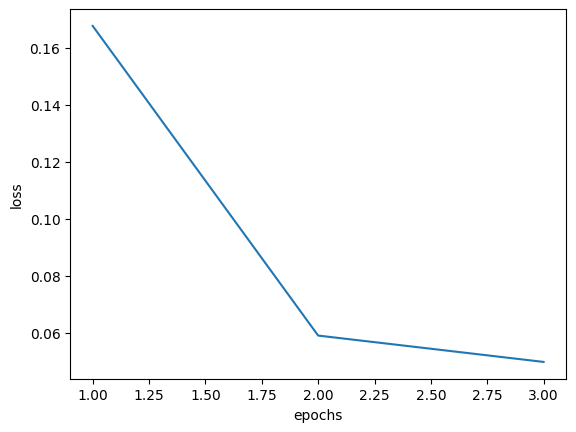

time needed for execution: --- 63.02687215805054 seconds ---
analyzing padding size:1
dimensions don't match
analyzing padding size:2
Mean loss epoch:1 is:0.14060089006554335
Mean loss epoch:2 is:0.05505814687727252
Mean loss epoch:3 is:0.04576122992128755


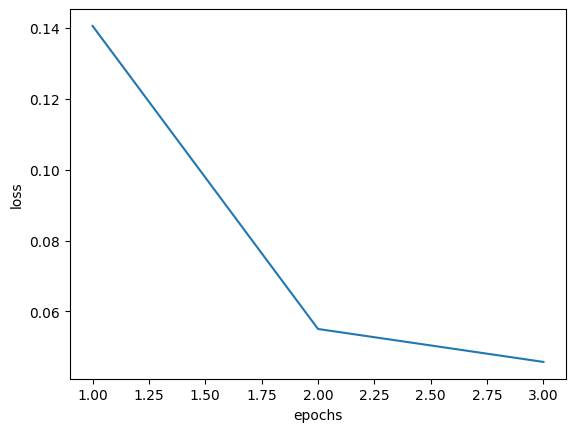

time needed for execution: --- 113.38543009757996 seconds ---
analyzing padding size:3
dimensions don't match
analyzing padding size:4
Mean loss epoch:1 is:0.18224682986658688
Mean loss epoch:2 is:0.0662475383184695
Mean loss epoch:3 is:0.058988282994832844


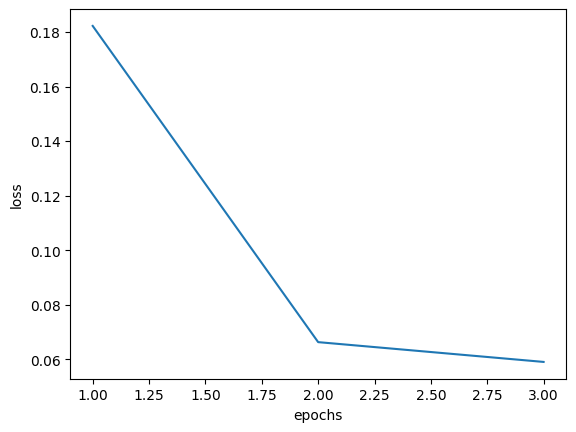

time needed for execution: --- 102.478590965271 seconds ---


Text(0, 0.5, 'loss')

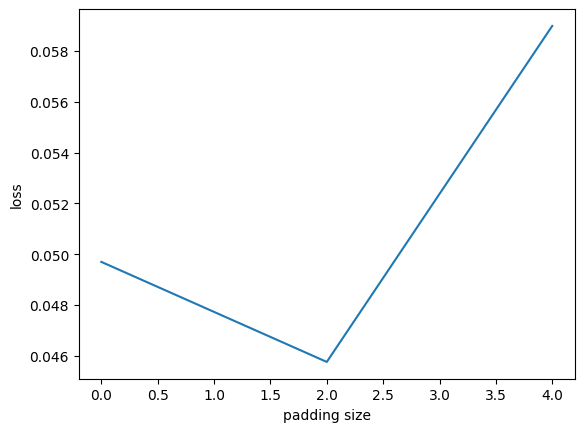

In [14]:
dimension_padding_list=[i for i in range(0,5)]
kernel_size=5
num_epochs=3
loss_per_dimension=[]
analyzed_dimensions=[]

for padding in dimension_padding_list:
    
    print("analyzing padding size:{}".format(padding))
    
    output_size_first_conv_layer=((28-kernel_size+2*padding)/1)+1
    output_size_first_max_pooling=((output_size_first_conv_layer-2)/2)+1
    output_size_second_conv_layer=((output_size_first_max_pooling-5+2*2)/1)+1
    output_size_second_max_pooling=((output_size_second_conv_layer-2)/2)+1
    
    if(output_size_second_max_pooling.is_integer()):
        
        start_time = time.time()
        
        cnn=CNN(kernel_size,int(output_size_second_max_pooling),padding)
        loss_func = nn.CrossEntropyLoss()   
        optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
        training_loss=np.array(train(num_epochs, cnn, loaders))
        loss_per_dimension.append(training_loss[-1])
        analyzed_dimensions.append(padding)
        
        del cnn
        del loss_func
        del optimizer
        
        print("time needed for execution: --- %s seconds ---" % (time.time() - start_time))
        
    else:
        print("dimensions don't match")
        
plt.plot(analyzed_dimensions,loss_per_dimension)
plt.xlabel("padding size")
plt.ylabel("loss")

### Solution exercise 5: 

To compare the performances of the Feed Forward Network and the Convolutional Network, the predictions skills have been evaluated on the same test dataset. We have also compare the time needed for the training procedure of the 2 models. When you evaluate a model is always important to find a compromise beetween accuracy and computational time. The Feed Forward Network has been implemented using pytorch. The performances obtained using the convolutional network are a little bit better, but of course the time needed for the training procedure is much more.   

Mean loss epoch:1 is:0.22210343031523128
Mean loss epoch:2 is:0.08466202423054105
Mean loss epoch:3 is:0.07083952889079229
Mean loss epoch:4 is:0.0649262717354577
Mean loss epoch:5 is:0.06257554112351499


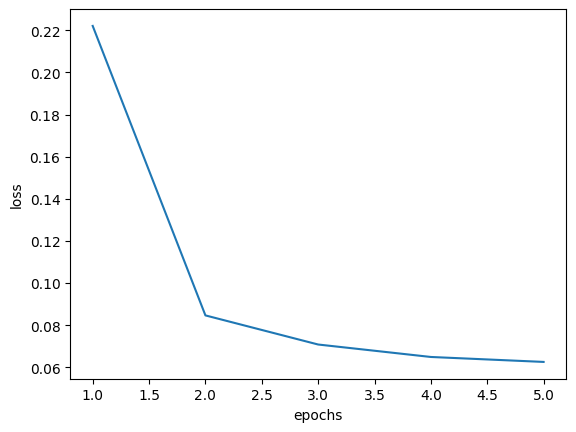

time needed to train the convolutional network: --- 151.9315459728241 seconds ---
Mean loss epoch:1 is:0.5292889635140697
Mean loss epoch:2 is:0.2456830780953169
Mean loss epoch:3 is:0.194180474995325
Mean loss epoch:4 is:0.16190906965484222


In [ ]:
kernel_dimension=5
padding=2

output_size_first_conv_layer=((28-kernel_dimension+2*padding)/1)+1
output_size_first_max_pooling=((output_size_first_conv_layer-2)/2)+1
output_size_second_conv_layer=((output_size_first_max_pooling-5+2*2)/1)+1
output_size_second_max_pooling=((output_size_second_conv_layer-2)/2)+1

num_epochs=5

start_time = time.time()

cnn=CNN(kernel_dimension,int(output_size_second_max_pooling))
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn.parameters(), lr = 0.01) 
train(num_epochs,cnn,loaders)


print("time needed to train the Convolutional Network: --- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

ffn=FFN(100,10)
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(ffn.parameters(), lr = 0.0005)  
train_ffn(num_epochs,ffn,loaders)

print("time needed to train the Feed Forward Network: --- %s seconds ---" % (time.time() - start_time))

def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            
            pred_y = torch.max(test_output, 1)[1]
            correct+=(pred_y == labels).sum().item() 
        pass
    accuracy=correct/len(loaders['test'])
    print('Test Accuracy of the Convolutional Network on the 10000 test images: %.2f' % accuracy) 
    pass

def test_ffn():
    # Test the model
    ffn.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in loaders['test']:
            test_output, last_layer = ffn(images)
            
            pred_y = torch.max(test_output, 1)[1]
            correct+=(pred_y == labels).sum().item() 
        pass
    accuracy=correct/len(loaders['test'])
    print('Test Accuracy of the FFN on the 10000 test images: %.2f' % accuracy) 
    pass

test()
test_ffn()